<a href="https://colab.research.google.com/github/raitharnett/tensorflow-great-barrier-reef/blob/main/cots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
%%bash
#upgrade pip
python -m pip install --upgrade pip
# upgrade kaggle and install API token
pip install --upgrade --force-reinstall --no-deps kaggle
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# download and unzip COTS data
kaggle competitions download -c tensorflow-great-barrier-reef
unzip -d  tensorflow-great-barrier-reef tensorflow-great-barrier-reef.zip 
# download an EfficientDet-D0 base model and apply transfer learning to train a COTS detection model
wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz 
tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz 
# clone and install TF models
git clone --depth 1 https://github.com/tensorflow/models
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time
import shutil
from pathlib import Path
from enum import Enum
from google.colab import data_table
data_table.enable_dataframe_formatter()
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

# COTS testing data
COTS_DATA = '/content/tensorflow-great-barrier-reef'
sys.path.insert(0, COTS_DATA)
import greatbarrierreef

COTS_DATA_IMAGES = os.path.join(COTS_DATA,'train_images')
COTS_DATASET = '/content/dataset'
Path(COTS_DATASET).mkdir(parents=True, exist_ok=True)
COTS_DATA_TRAIN_TF_RECORDS = f'{COTS_DATASET}/train'
COTS_DATA_TEST_TF_RECORDS = f'{COTS_DATASET}/test'
COTS_MODEL_DIR='/content/drive/MyDrive/cots/cots_efficientdet_d0'
Path(COTS_MODEL_DIR).mkdir(parents=True, exist_ok=True)

class COTSClass(Enum):
  COTS = 1

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import contextlib2

def create_cots_tf_example(row):
  with tf.io.gfile.GFile(row.image_path, 'rb') as fid:
    encodedJpg = fid.read()
  encodedJpgIO = io.BytesIO(encodedJpg)
  image = Image.open(encodedJpgIO)
  width = image.size[0]
  height = image.size[1]
  fileName = f'{row.image_id}'.encode('utf8')
  imageFormat = 'jpeg'.encode('utf8')
  classesText = []
  classes = []
  annotations = json.loads(row.annotations.replace("'", '"'))
  xmin = []
  ymin = []
  xmax = []
  ymax = []
  for annotation in annotations:
    xmin.append(annotation['x'] / width) 
    xmax.append((annotation['x'] + annotation['width']) / width) 
    ymin.append(annotation['y'] / height) 
    ymax.append((annotation['y'] + annotation['height']) / height) 
    classesText.append(COTSClass.COTS.name.encode('utf8'))
    classes.append(COTSClass.COTS.value)

  tfExample = tf.train.Example(features=tf.train.Features(feature={
    'image/height': dataset_util.int64_feature(height),
    'image/width': dataset_util.int64_feature(width),
    'image/filename': dataset_util.bytes_feature(fileName),
    'image/source_id': dataset_util.bytes_feature(fileName),
    'image/encoded': dataset_util.bytes_feature(encodedJpg),
    'image/format': dataset_util.bytes_feature(imageFormat),
    'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
    'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
    'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
    'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
    'image/object/class/text': dataset_util.bytes_list_feature(classesText),
    'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))

  return tfExample

def load_cots(df, basePath, numShards=10):
  with contextlib2.ExitStack() as tfRecordCloseStack:
    outputTFRecords = tf_record_creation_util.open_sharded_output_tfrecords(tfRecordCloseStack, basePath, numShards)
    for index, row in df.iterrows():
      tfExample = create_cots_tf_example(row)
      outputShardIndex = index % numShards
      outputTFRecords[outputShardIndex].write(tfExample.SerializeToString())

In [5]:
cots_df = pd.read_csv(os.path.join(COTS_DATA,'train.csv'))
cots_df['image_path'] = cots_df.apply(lambda r: os.path.join(COTS_DATA_IMAGES,f"video_{r.video_id}",f"{r.video_frame}.jpg"), axis=1)
cots_train_test_split = train_test_split(cots_df, train_size = 0.8)

In [11]:
cots_tf_record_keys = [COTS_DATA_TRAIN_TF_RECORDS, COTS_DATA_TEST_TF_RECORDS]
cots_train_test_data = {cots_tf_record_keys[i]: cots_train_test_split[i] for i in range(len(cots_train_test_split))}
for base_path, df in cots_train_test_data.items():
  load_cots(df, base_path)

In [6]:
from string import Template

TRAINING_STEPS = 5000
WARMUP_STEPS = 500
PIPELINE_CONFIG_PATH='dataset/pipeline.config'
LABEL_MAP_PATH='dataset/label_map.pbtxt'

shutil.copy('/content/drive/MyDrive/cots/label_map.txt', LABEL_MAP_PATH)
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)
with open('/content/drive/MyDrive/cots/config_file_template.txt', mode='r') as f:
  config_file_template = f.read()
pipeline = Template(config_file_template).substitute(training_steps=TRAINING_STEPS, warmup_steps=WARMUP_STEPS)
with open(PIPELINE_CONFIG_PATH, mode='w') as f:
  f.write(pipeline)

In [ ]:
%%bash -s "$COTS_MODEL_DIR" "$PIPELINE_CONFIG_PATH"
MODEL_DIR=$1
PIPELINE_CONFIG_PATH=$2
# train model
python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --alsologtostderr
# evaluate model
python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --checkpoint_dir=$MODEL_DIR \
    --eval_timeout=0 \
    --alsologtostderr
# save model
python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --trained_checkpoint_dir=$MODEL_DIR \
    --output_directory=$MODEL_DIR/output \
    --alsologtostderr

In [8]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn_tf_odt = tf.saved_model.load(os.path.join(os.path.join(COTS_MODEL_DIR, 'output'), 'saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {elapsed_time} seconds')

Elapsed time: 41.3588330745697 seconds


In [7]:
env = greatbarrierreef.make_env()   # initialize the environment

In [ ]:
DETECTION_THRESHOLD = 0.3

submission_dict = {
    'id': [],
    'prediction_string': [],
}
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (image_np, sample_prediction_df) in iter_test:
  height, width, _ = image_np.shape
  input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn_tf_odt(input_tensor)
  num_detections = detections['num_detections'][0].numpy().astype(np.int32)
  predictions = []
  for index in range(num_detections):
      score = detections['detection_scores'][0][index].numpy()
      if score < DETECTION_THRESHOLD:
          continue

      bbox = detections['detection_boxes'][0][index].numpy()
      y_min = int(bbox[0] * height)
      x_min = int(bbox[1] * width)
      y_max = int(bbox[2] * height)
      x_max = int(bbox[3] * width)
      
      bbox_width = x_max - x_min
      bbox_height = y_max - y_min
      predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
  prediction_str = ' '.join(predictions)
  sample_prediction_df['annotations'] = prediction_str
  env.predict(sample_prediction_df)

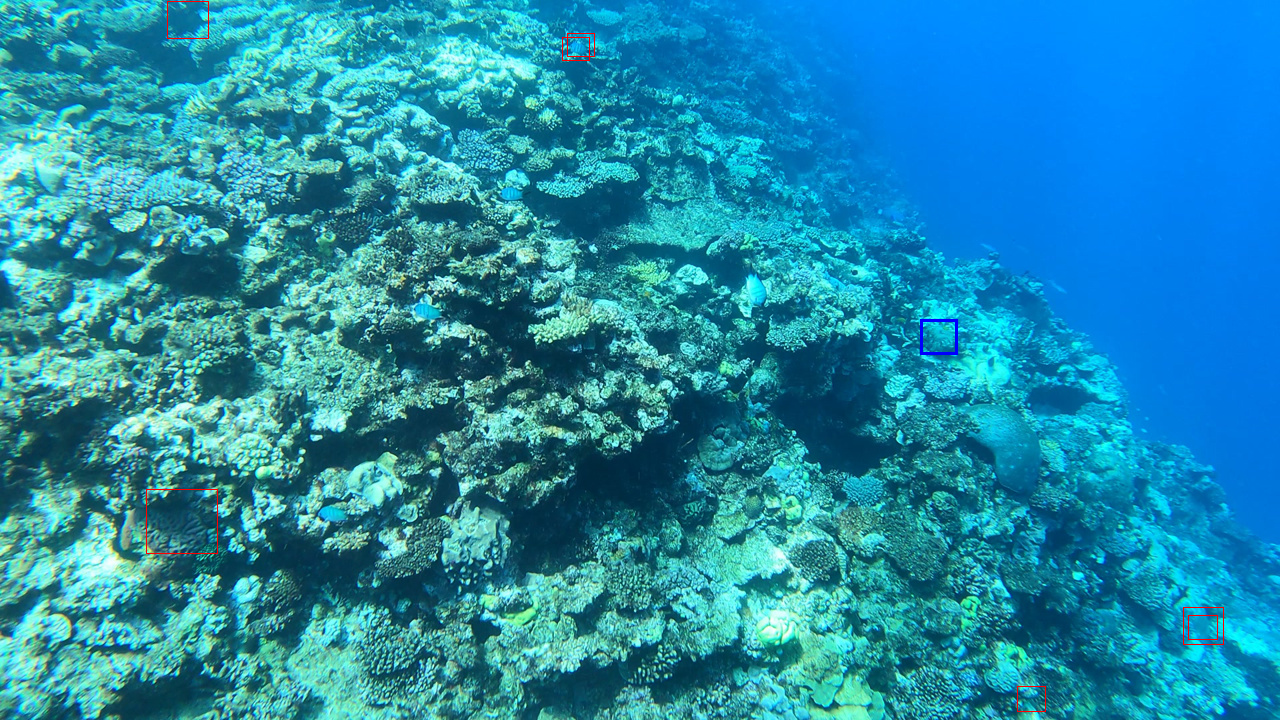

In [13]:
image_row = cots_train_test_split[0][cots_train_test_split[0].index == 256].iloc[0]
image_path = image_row.image_path
annotations =  json.loads(image_row.annotations.replace("'", '"'))
image_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(io.BytesIO(image_data))
(image_width, image_height) = image.size
xmin = []
ymin = []
xmax = []
ymax = []
for annotation in annotations:
  xmin.append(annotation['x']) 
  xmax.append((annotation['x'] + annotation['width'])) 
  ymin.append(annotation['y']) 
  ymax.append((annotation['y'] + annotation['height'])) 

image_np = np.array(image.getdata()).reshape((image_height, image_width, 3)).astype(np.uint8)
input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn_tf_odt(input_tensor)

num_detections = detections['num_detections'][0].numpy().astype(np.int32)
for index in range(num_detections):
    score = detections['detection_scores'][0][index].numpy()
    if score < 0.03:
      continue
    bbox = detections['detection_boxes'][0][index].numpy()
    y_min = int(bbox[0] * image_height)
    x_min = int(bbox[1] * image_width)
    y_max = int(bbox[2] * image_height)
    x_max = int(bbox[3] * image_width)
    shape = [x_min, y_min, x_max, y_max]
    ImageDraw.Draw(image).rectangle(shape, outline ="red", width=1)

for index in  range(len(xmin)):
  shape = [xmin[index], ymin[index], xmax[index], ymax[index]]
  ImageDraw.Draw(image).rectangle(shape, outline ="blue", width=3)
  
display(image)